In [3]:
from collections import defaultdict
import numpy as np

def softmax(x):
    if np.sum(np.exp(x), axis=0) == 0:
        return np.exp(x) / 1
    else:
        return np.exp(x) / np.sum(np.exp(x), axis=0)

def minmax(x, i):
    return x[i] / (np.max(x) - np.min(x))

def predict(x, i):
    return minmax(x, i)

def soft_vote(*arrays, weights=None):
    # Convert the arrays to numpy arrays
    arrays = [np.array(arr) for arr in arrays]
    
    # Check if weights are provided, otherwise set equal weights
    if weights is None:
        weights = [1] * len(arrays)
    else:
        weights = np.array(weights)
    
    # Weighted average of the predicted probabilities
    soft_voting_result = np.average(arrays, axis=0, weights=weights)
    
    # Select the class with the highest average probability
    final_prediction = np.argmax(soft_voting_result)
    
    return final_prediction

def average_probabilities(*arrays, weights=None):
    # Convert the arrays to numpy arrays
    arrays = [np.array(arr) for arr in arrays]

    # Check if weights are provided, otherwise set equal weights
    if weights is None:
        weights = [1] * len(arrays)
    else:
        weights = np.array(weights)

    # Weighted average of the predicted probabilities
    average_result = np.average(arrays, axis=0, weights=weights)

    # Select the class with the highest average probability
    final_prediction = np.argmax(average_result)

    return final_prediction

def ranked_voting(probabilities, weights):
    # Ensure that each voter's array sums to 1 (probabilities)
    for preference in probabilities:
        total_probability = sum(preference)
        if not (0.99 <= total_probability <= 1.01):  # Allowing a small tolerance for floating-point precision
            raise ValueError("Probabilities in each array should sum to approximately 1.")

    # Ensure the number of weights matches the number of voters
    if len(weights) != len(probabilities):
        raise ValueError("Number of weights should match the number of voters.")

    # Initialize candidates and their weighted scores
    candidates = list(range(len(probabilities[0])))
    scores = defaultdict(float)

    # Calculate scores based on weighted preferences
    for i, preference in enumerate(probabilities):
        weight = weights[i]
        for j, candidate in enumerate(candidates):
            scores[candidate] += weight * preference[j]

    # Find the candidate with the highest score
    winner = max(candidates, key=lambda x: scores[x])

    # Return the index of the winning candidate
    return winner

def predict_team(X, weights, i):
    # Get the votes for each candidate
    votes = [predict(x, i) for x in X]
    #votes = [softmax(x) for x in votes]
    #votes = [x * weights[i] for i, x in enumerate(votes)]

    prediction = soft_vote(*votes, weights=weights)
    #prediction = average_probabilities(*votes, weights=weights)
    #prediction = ranked_voting(votes, weights=weights)

    #comb = np.sum(votes, axis=0)
    #prediction = np.argmax(comb, axis=0)
    return prediction

In [4]:
import numpy as np
from keras.datasets import cifar10

(X_train_org, Y_train), (X_test_org, Y_test) = cifar10.load_data()

  
# Base class sums
Y_ts_threshold = np.loadtxt("class_sums/CIFAR10AdaptiveThresholding_99_2000_500_10.0_10_32_1.txt", delimiter=",")
Y_ts_thermometer_3 = np.loadtxt("class_sums/CIFAR10ColorThermometers_99_2000_1500_2.5_3_8_32_1.txt", delimiter=",")
Y_ts_thermometer_4 = np.loadtxt("class_sums/CIFAR10ColorThermometers_99_2000_1500_2.5_4_8_32_1.txt", delimiter=",")
Y_ts_hog = np.loadtxt("class_sums/CIFAR10HistogramOfGradients_99_2000_50_10.0_0_32_0.txt", delimiter=",")

# New class sums
Y_ts_canny = np.loadtxt("class_sums/CIFAR10CannyHoughLines_100_2000_500_10.0_16_32_1.txt", delimiter=",")
Y_ts_otsu = np.loadtxt("class_sums/CIFAR10Otsu_100_2000_500_10.0_16_32_1.txt", delimiter=",")
Y_ts_thresh_inv = np.loadtxt("class_sums/CIFAR10ThresInvBlur_100_2000_500_10.0_16_32_1.txt", delimiter=",")
Y_ts_thermometer_2 = np.loadtxt("class_sums/CIFAR102x2ColorThermometers_100_2000_1500_2.5_2_32_1.txt", delimiter=",")
Y_ts_thermometer_5 = np.loadtxt("class_sums/CIFAR105x5ColorThermometers_100_2000_1500_2.5_5_32_1.txt", delimiter=",")

C:\Users\kjell\AppData\Local\Temp\ipykernel_35456\3688708536.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  is_correct = int(is_correct)


In [5]:
import matplotlib.pyplot as plt

def plot_accuracy(X, min_class_sum=-4000, max_class_sum=10000, step=100, filename=None, show=False, limit=0.95):
    class_sums = np.arange(min_class_sum, max_class_sum, step)
    accuracies = []
    totals = []

    for class_sum_step in class_sums:
        total = 0
        correct = 0

        for i in range(X.shape[0]):
            votes = X[i]

            prediction = np.argmax(votes, axis=0)
            class_sum = votes[prediction]

            if class_sum >= class_sum_step:
                total += 1
                is_correct = prediction == Y_test[i]

                if is_correct:
                    correct += 1

        totals.append(total)

        if total > 0:
            accuracies.append(correct / total)
        else:
            accuracies.append(1)

    # Find the class sum where the accuracy is more than 0.90
    for i, acc in enumerate(accuracies):
        if acc > limit:
            break
    
    print(f"X: {filename}, Class sum: {class_sums[i]}, Totals: {totals[i]}, Accuracy: {accuracies[i]}, Total accuracy: {accuracies[0]}")

    # Plot the accuracies with respect to the class sums
    # Add grid lines
    plt.title(f"Accuracy {filename}")
    plt.plot(class_sums, accuracies)
    plt.xlabel("Class sum")
    plt.ylabel("Accuracy")
    plt.legend(["acc per class sum"], loc="upper left")
    
    # Plot the total number of images with respect to the class sums
    plt.twinx()
    plt.plot(class_sums, totals, color="orange")
    plt.ylabel("Total")
    plt.legend(["# class sum"], loc="upper right")

    if show:
        plt.show()

    if filename is not None:
        filename = f"{filename}.png"
        plt.savefig(filename)
        plt.close()

In [6]:
plot_accuracy(Y_ts_canny, filename="graphs/acc_canny")
plot_accuracy(Y_ts_otsu, filename="graphs/acc_otsu")
plot_accuracy(Y_ts_thresh_inv, filename="graphs/acc_thresh_inv")
plot_accuracy(Y_ts_thermometer_2, filename="graphs/acc_thermometer_2")
plot_accuracy(Y_ts_thermometer_5, filename="graphs/acc_thermometer_5")
plot_accuracy(Y_ts_threshold, filename="graphs/acc_threshold")
plot_accuracy(Y_ts_thermometer_3, filename="graphs/acc_thermometer_3")
plot_accuracy(Y_ts_thermometer_4, filename="graphs/acc_thermometer_4")
plot_accuracy(Y_ts_hog,min_class_sum=-10, max_class_sum=100, step=1, filename="acc_hog")

X: graphs/acc_canny, Class sum: 2800, Totals: 11, Accuracy: 1.0, Total accuracy: 0.3952
X: graphs/acc_otsu, Class sum: 1900, Totals: 163, Accuracy: 0.9570552147239264, Total accuracy: 0.4291
X: graphs/acc_thresh_inv, Class sum: 2300, Totals: 140, Accuracy: 0.9785714285714285, Total accuracy: 0.4908
X: graphs/acc_thermometer_2, Class sum: 4500, Totals: 206, Accuracy: 0.9514563106796117, Total accuracy: 0.5672
X: graphs/acc_thermometer_5, Class sum: 4400, Totals: 148, Accuracy: 0.9527027027027027, Total accuracy: 0.5754
X: graphs/acc_threshold, Class sum: 2100, Totals: 570, Accuracy: 0.9596491228070175, Total accuracy: 0.5701
X: graphs/acc_thermometer_3, Class sum: 4700, Totals: 1108, Accuracy: 0.9521660649819494, Total accuracy: 0.6212
X: graphs/acc_thermometer_4, Class sum: 4300, Totals: 1438, Accuracy: 0.952712100139082, Total accuracy: 0.6272
X: acc_hog, Class sum: 59, Totals: 1786, Accuracy: 0.9518477043673013, Total accuracy: 0.6388216303470541


**Argmax + Weights**

Team Accuracy: 76.3
Correct: 7627, Total: 10000, Incorrent: 2373

**SoftVote + Weights**

Team Accuracy: 76.3
Correct: 7627, Total: 10000, Incorrent: 2373

**Average Probabilities + Weights**

Team Accuracy: 76.3
Correct: 7627, Total: 10000, Incorrent: 2373

**Ranked Voting + Weights + Softmax**

Team Accuracy: 76.1
Correct: 7613, Total: 10000, Incorrent: 2387

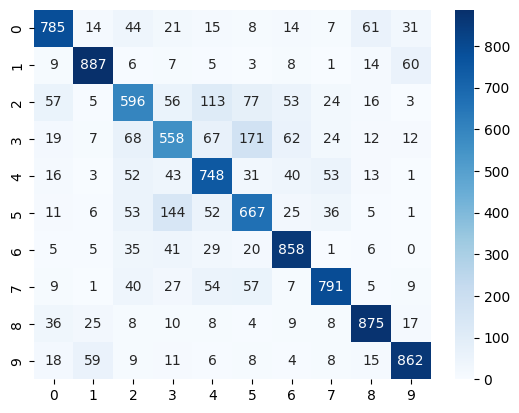

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn

# Ensure the arrays are numpy arrays
Y_test = np.array(Y_test)
predicted_values = np.array(predicted_values)
 
matrix = confusion_matrix(Y_test, predicted_values)

heatmap = seaborn.heatmap(matrix, annot=True, fmt='g', cmap='Blues')
 
figure = heatmap.get_figure()
figure.savefig("cm_team.png", dpi=400)

# Calculate  the average value in Y_ts_threshold in each class
average_values = np.zeros((10, 2), dtype=np.float32)

sums = np.zeros(10, dtype=np.float32)

for i in range(Y_ts_threshold.shape[0]):
    for j in range(10):
        sums[j] += Y_ts_threshold[i][j]
    
#print(sums / Y_ts_threshold.shape[0])
#print(average_values)

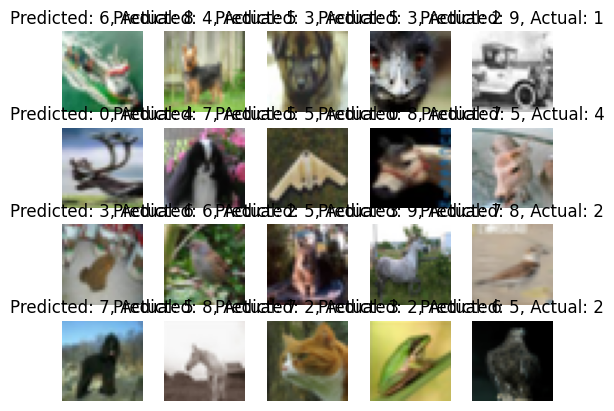

In [21]:
# Plot 20 of the incorrect predictions

import matplotlib.pyplot as plt

incorrect = np.where(predicted_values != Y_test)[0]

for i in range(20):
    index = incorrect[i]
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_test_org[index])
    plt.title(f"Predicted: {predicted_values[index]}, Actual: {Y_test[index]}")
    plt.axis('off')

plt.show()